In [1]:
#This code was built from Andrej Karpathy's video "Let's build GPT" with some modifications
#https://youtu.be/kCc8FmEb1nY?si=huVzeZV99JqPLTF8
import torch
import torch.nn as nn
from torch.nn import functional as F
from plotAllLosses import Plotter, avg_loss
import time

from GptDatasets import TextDataset

from torch.utils.data import DataLoader

import tiktoken

In [2]:
block_size = 128
n_embd = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class LanguageBlock(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.attn = AttentionMultiHead(n_head, head_size, n_embd)
        self.ffwd = FeedForwardBlock(n_embd)
        
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.embedding_size = n_embd
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        numBlocks = 6
        blocks = []
        for _ in range(numBlocks):
            blocks.append(LanguageBlock(n_embd, 16))
        blocks.append(nn.LayerNorm(n_embd))
        self.blocks = nn.Sequential(*blocks)
        
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    
    def forward(self, idx, targets=None):
        idx = idx.to(device)[:,-block_size:]
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T).to(device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits  = self.lm_head(x)
        
        if targets is None:
            loss = None
        else:
            targets = targets.to(device)
            B, T, C = logits.shape
            logits  = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            # focus only on the last time step
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [4]:
class AttentionHead(nn.Module):
    def __init__(self, head_size, n_embd):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(n_embd,n_embd)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        
        v   = self.value(x)
        out = wei @ v
        return out

class AttentionMultiHead(nn.Module):
    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size, n_embd) for _ in range(num_heads)])
        self.proj  = nn.Linear(n_embd, n_embd)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out
    
class FeedForwardBlock(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),
            nn.ReLU(),
            nn.Linear(n_embd * 4, n_embd),
        )
    def forward(self, x):
        out = self.net(x)
        return out

In [5]:
batch_size = 64
checkpointPath = "X:/Jupyter/HobbyProjects/SeinfeldGPT/checkpoints/"
seinfeldSrc = "X:/Datasets/Seinfeld/scripts.txt"
booksSrc    = "X:/Datasets/Books/books.txt"

In [6]:
#sub word tokenizer
enc = tiktoken.get_encoding('gpt2')
encode = enc.encode
decode = enc.decode
#gpt2 tokenizer has 50257 tokens in the vocab
vocab_size = enc.n_vocab

In [7]:
#DataLoaders

#Dataset created from all Seinfeld episode scripts web scraped from
#https://www.seinfeldscripts.com/seinfeld-scripts.html
#Roughly 330k lines of text
#uses 22443 tokens from the tiktoken gpt2 tokenizer
train_seinfeld = DataLoader(
    dataset = TextDataset(seinfeldSrc, enc, block_size),
    batch_size = batch_size,
    shuffle=True
)
#Dataset create from many of the top 100 books from
#https://gutenberg.org/browse/scores/top
#Roughly 1.3 million lines of text
#uses 38831 tokens from the tiktoken gpt2 tokenizer
train_books = DataLoader(
    dataset = TextDataset(booksSrc, enc, block_size),
    batch_size = batch_size,
    shuffle=True
)

In [8]:
startEpoch = 240
model = LanguageModel(vocab_size, n_embd).to(device)
model.load_state_dict(torch.load("X:/Jupyter/HobbyProjects/SeinfeldGPT/checkpoints/seinGPT_half_" + str(startEpoch) + ".pth"))
genStarter = torch.zeros((1,1), dtype=torch.long).to(device)
print(decode(model.generate(genStarter, 200)[0].tolist()))

! suddenly it became rivets! What
 dared he fly, little Cosette? he must rise again.

Rook him to the right. He, walking straight up, caught sight of Fauchele
everybody.

A general row of dogs was babbule and a hawkering.




CHAPTER III—and close beside a column, swept from the full ramshackle
slabs of the wagon.

The moon was illuminated off from the thoroughfare to the west divan of
the brick walls above the green road.

“It is perfectly well,” chimed in Count Andrea’s horse, “that you
are at the press of the Count of Morcerf’s; that he should have died when
Souffé at night.”


“I saw his dearest decrepitude.”


Negoreau
suddenly, who was pulling


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

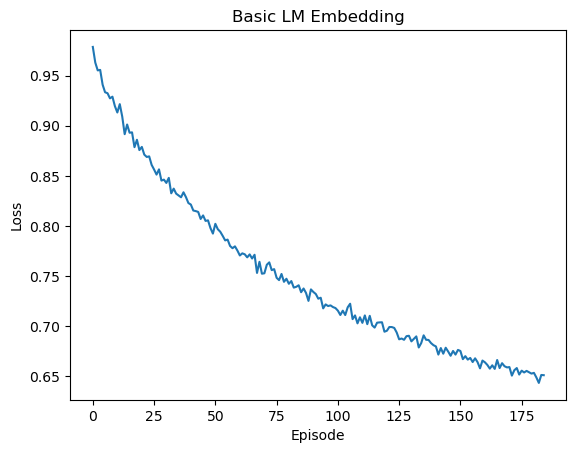

[Epoch 185/250] 
[Training: 0.651077] 

Elapsed Time 13:2:27


In [ ]:
epochs = 250
checkpoint_interval = 10
loss_interval = 100

plotter = Plotter("Basic LM Embedding", ["Training"], epochs-startEpoch, 1)
model.train()
for epoch in range(startEpoch+1, epochs):
    counter     = 0
    trainLosses = []
    
    for i, (sample, target) in enumerate(train_books):
        logits, loss = model(sample, target)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if len(trainLosses) < loss_interval:
            trainLosses.append(loss.item())
        else:
            trainLosses[counter % loss_interval] = loss.item()
        counter += 1
    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), checkpointPath + "seinGPT_Half_" + str(epoch) + ".pth")
    plotter.sampleAndPlot([avg_loss(trainLosses)])

In [13]:
torch.save(model.state_dict(), checkpointPath + "seinGPT_Half.pth")
model.eval()
print(decode(model.generate(genStarter, 500)[0].tolist()))

!

ANTONY.
O that I
Did kill those Regan men on my shoulders.
O bah!

O Martius, Eros, Eros, Eros, Eros, Eumaeus,
And Mercury with mine for mine own harm,
Fall in the mire, and hear me speak.

LEPIDUS.
I do not like to think what I heard of here.
You do attend me on every one, that different natures
Are inly burial, and have given me reasons of both.

FIRST GENTLEMAN.
But is this all we have in hand?
Did we desire it with a better grace?

SCHOOLMASTER.
List you? The cozening will come?

SECOND GENTLEMAN.
Ay me, so please your majesty.

THIRD GENTLEMAN.
Yes, indeed will I, at the least, take a turn, sir.

FIRST GENTLEMAN.
That by force of force she is made of, sir.

THIRD GENTLEMAN.
She is delivered from mercy by theAngle.

FIRST GENTLEMAN.
But this will not charm a broken rancorous fellow.
’Tis the king invention to the prison.

SECOND GENTLEMAN.
That will I tell you.

THIRD GENTLEMAN.
Go to, to each thing I know of;
At one in particular resort,
And see the battle, looks on one king’s 

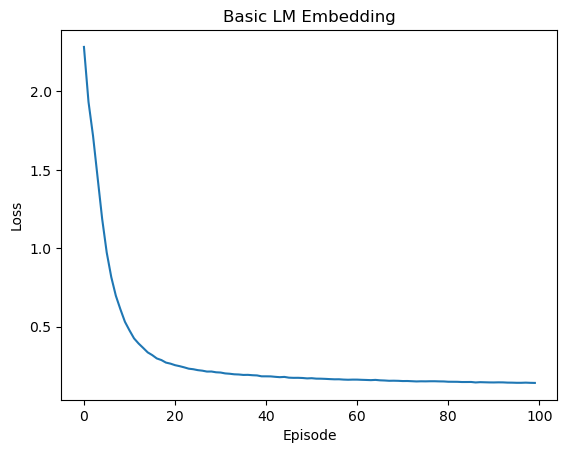

[Epoch 100/100] 
[Training: 0.141864] 

Elapsed Time 0:54:36


In [10]:
epochs = 100
loss_interval = 100

plotter = Plotter("Basic LM Embedding", ["Training"], epochs, 1)
model.train()
for epoch in range(epochs):
    counter     = 0
    trainLosses = []
    
    for i, (sample, target) in enumerate(train_seinfeld):
        logits, loss = model(sample, target)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if len(trainLosses) < loss_interval:
            trainLosses.append(loss.item())
        else:
            trainLosses[counter % loss_interval] = loss.item()
        counter += 1
    plotter.sampleAndPlot([avg_loss(trainLosses)])

In [11]:
torch.save(model.state_dict(), checkpointPath + "seinGPT.pth")
model.eval()
print(decode(model.generate(genStarter, 500)[0].tolist()))

!


               PARRY
I just wanted to thank you again for 
saving my life.


               JERRY
She saved your life?


               PARRY
I had skin cancer.


               JERRY
Skin cancer! Damn.



(Elaine's apartment. She and Jerry collect their jackets and make 
their way


to the door.


               JERRY
Yeah, that's the rule.


               ELAINE
What do you mean, ""He doesn't."" He's 
a great

body, yes, he's trying to get in on his way, ""Dings 
to thewalk"" He meets with ""Hi"")


               GEORGE
You put a hot meat on?


               ELAINE
No no, I can get their massage out.


               GEORGE
Oh.


New scene.

Jerry and George are in line outside Jerry's apartment.


               JERRY
See ya.


               GEORGE
""THIRTY MINUTES EARLIER"")


               JERRY
I mean, we had a deal, Newman. And you 
were supposed to give my your birthday 
wish. And now you've wated it!


               GEORGE
It's only a few blocks.


               JER

In [15]:
a = "\t\tNEWMAN\nHello Jerry."
prompt = torch.tensor(enc.encode(a))[None,:].to(device)
print(decode(model.generate(prompt, 500)[0].tolist()))

		NEWMAN
Hello Jerry.


               SETH
Yea, ya.


               JERRY
Hi Sue Ellen.


               SUE ELLEN
I'm surprised to see you here. Come 
to catch a glimpse of


high society?


               ELAINE
(faked laughter) Oh. Uh, hello. 
Yeah, yeah, yeah.


               SUE ELLEN
Uh, that's it.


               ELAINE
What's the difference?


               SUE ELLEN
(Caving in) I told you I was having 
some gas.


               ELAINE
(Hotel) You know, I know.


               SUE ELLEN
I don't like the move.


               ELAINE
Yeah, I think it's the same.


               SUE ELLEN
Shouldn't he elevate his legs?


               JERRY
Good.


               ELAINE
Congratulations! We'll never find you.


               SUE ELLEN
No.


               ELAINE
Yeah, alright, I gotta go.


               SUE ELLEN
Uh, that's right.


               ELAINE
Yeah, well, what's the matter?



